In [36]:
from loadphantom import BreastPhantomReader
file_path = "../../data/breast/"
reader = BreastPhantomReader(file_path)

Phantom ID 012304 loaded successfully.
Dimensions (s1, s2, s3): (215, 328, 212)
Classification: 4


In [37]:
freq = 1. # GHz
epsilon_rb = 10.
sigma_b = 0.5

reader.set_immersion_medium_properties(dielectric_constant=epsilon_rb,
                                       conductivity=sigma_b)

epsilon_r, sigma = reader.calculate_dielectric_properties(
    freq, model='debye'
)

Immersion medium properties set: εr=10.0, σ=0.5 S/m


In [38]:
import numpy as np
# Find locations where relative permittivity equals zero
zero_locations = (epsilon_r == 0)
print(f"Found {zero_locations.sum()} locations with epsilon_r = 0")

# Get the material type at those locations
if zero_locations.any():
    # Find the first occurrence of zero permittivity
    zero_indices = np.where(zero_locations)
    first_zero_idx = (zero_indices[0][0], zero_indices[1][0], zero_indices[2][0])
    
    # Check the material type at that location
    material_type = reader.mtype_grid[first_zero_idx]
    print(f"Material type at zero permittivity location {first_zero_idx}: {material_type}")
    
    # Check what this material type represents
    print(f"Material type value: {material_type}")
else:
    print("No locations with epsilon_r = 0 found")

Found 0 locations with epsilon_r = 0
No locations with epsilon_r = 0 found


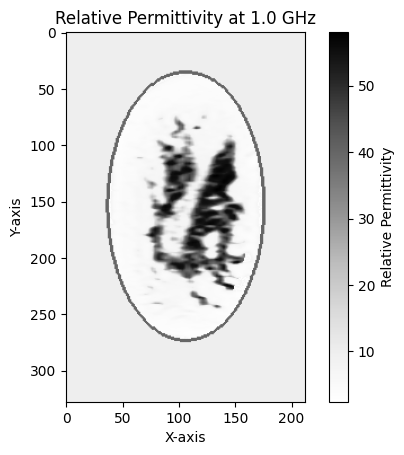

In [39]:
from matplotlib import pyplot as plt
plt.imshow(epsilon_r[140, :, :], cmap='Greys')
plt.colorbar(label='Relative Permittivity')
plt.title(f'Relative Permittivity at {freq} GHz')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

Degrees of freedom: 17


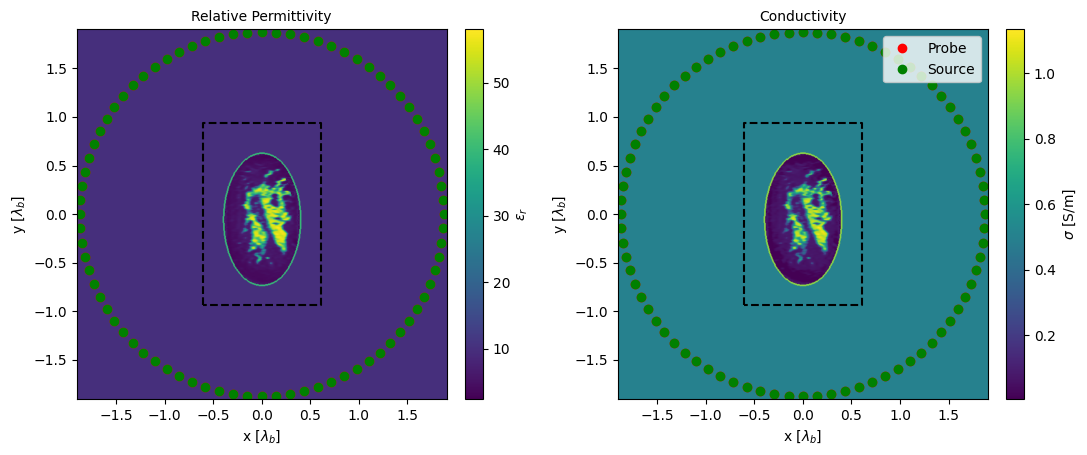

In [40]:
import numpy as np
import sys
sys.path.insert(1, '../../eispy2d/library/')
import configuration as cfg

epsr = np.squeeze(epsilon_r[140, :, :])
sig = np.squeeze(sigma[140, :, :])

instance_name = 'breastphantom'
dx = dy = 0.5e-3 # 0.5 mm
Lx, Ly = epsr.shape[1] * dx, epsr.shape[0] * dy
max_epsilon_r = epsr.max()
object_radius = min([Lx, Ly]) / 2.0
DOF = cfg.degrees_of_freedom(object_radius, frequency=freq*1e9,
                             epsilon_r=max_epsilon_r)
print(f"Degrees of freedom: {DOF}")
NS = NM = 80
Ro = max([Lx, Ly])
image_size = [Ly, Lx]
E0 = 1.

config = cfg.Configuration(name=instance_name + '.cfg',
                           number_measurements=NM,
                           number_sources=NS,
                           observation_radius=Ro,
                           frequency=freq*1e9,
                           background_permittivity=epsilon_rb,
                           background_conductivity=sigma_b,
                           image_size=image_size,
                           wavelength_unit=False,
                           magnitude=E0)

config.draw(epsr=epsr, sig=sig, show=True)

4.921361336730085
9.215920889008201e-17
Configuration name: breastphantom.cfg
Filepath = 
Number of measurements: 80
Number of sources: 80
Observation radius: 1.640e-01 [m]
Image domain size: 1.060e-01 x 1.640e-01 [m]
Background relative permittivity: 10.0
Background conductivity: 5.000e-01 [S/m]
Frequency: 1.083e+09 [Hz]
Background wavelength: 8.756e-02 [m]
Background wavenumber: 7.695e+01-2.778e+01j [1/m]


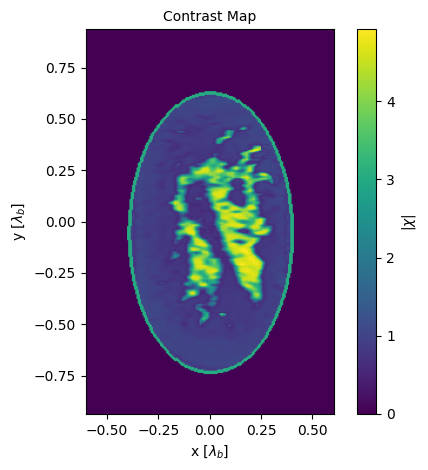

Input name: breastphantom.ipt
Configuration file: breastphantom.cfg
Images Resolution: 328x212
Relative Permit. map shape: 328x212
Conductivity map shape: 328x212
Indicators: ['zeta_s', 'zeta_p', 'objective_function']
Degrees of Non-Linearity: None


In [ ]:
import inputdata as ipt
import result as rst

test = ipt.InputData(name=instance_name + '.ipt',
                     configuration=config,
                     rel_permittivity=epsr,
                     conductivity=sig,
                     indicators=[rst.SHAPE_ERROR, rst.POSITION_ERROR,
                                 rst.OBJECTIVE_FUNCTION])

# test.compute_dnl()
test.draw(show=True, image=ipt.CONTRAST)
print(test)

In [7]:
# import mom_cg_fft as mom
# forward = mom.MoM_CG_FFT(tolerance=1e-3, maximum_iterations=5_000)
# _ = forward.solve(test)

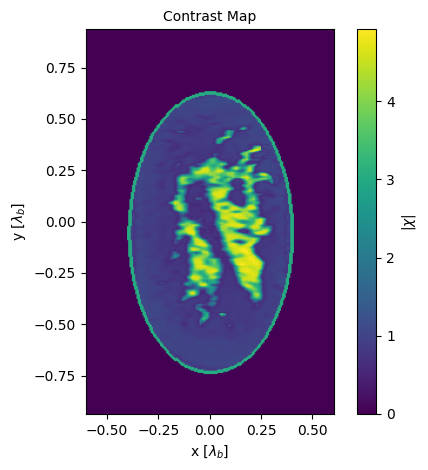

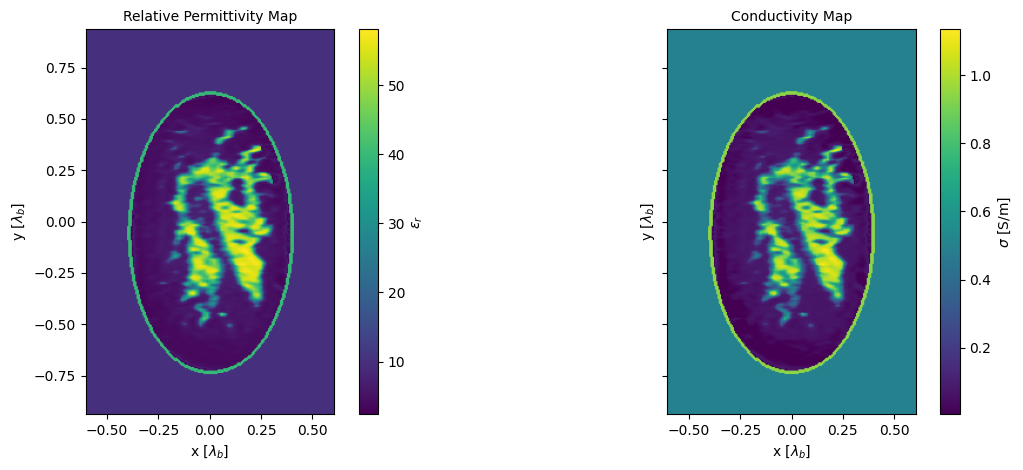

Input name: breastphantom.ipt
Configuration file: breastphantom.cfg
Images Resolution: 328x212
Scattered field - measurement samples: 80
Scattered field - source samples: 80
Total field - measurement samples: 69536
Total field - source samples: 80
Relative Permit. map shape: 328x212
Conductivity map shape: 328x212
Indicators: ['zeta_s', 'zeta_p', 'objective_function']
Degrees of Non-Linearity: 0.0160


In [44]:
import inputdata as ipt
import richmond as ric
resolution = (40, 40)
test = ipt.InputData(import_filename=instance_name + '.ipt',
                     import_filepath='../../data/breast/')
discretization = ric.Richmond(configuration=test.configuration,
                              elements=resolution)
test.draw(show=True)
test.draw(show=True, image=ipt.BOTH_PROPERTIES)
print(test)

Method: Subspace-based Optimization Method
Alias: som
Input Data: breastphantom.ipt
Discretization: Richmond Method (40x40)
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Stop Criteria
Maximum number of iterations: 30


/home/andre/GitHub/artigoindicadores/experiments/breast/../../eispy2d/library/result.py:1941: RuntimeWarning: divide by zero encountered in scalar divide
  area_diff = np.sum(diff)/np.sum(masko)*100


Iteration: 1 -  Shape: inf, Position: 13.13, Ob. Func.: 9.146e+00,
Iteration: 2 -  Shape: inf, Position: 10.91, Ob. Func.: 6.862e+00,
Iteration: 3 -  Shape: inf, Position: 22.26, Ob. Func.: 5.094e+00,
Iteration: 4 -  Shape: inf, Position: 22.07, Ob. Func.: 4.211e+00,
Iteration: 5 -  Shape: inf, Position: 25.84, Ob. Func.: 3.608e+00,
Iteration: 6 -  Shape: inf, Position: 28.29, Ob. Func.: 3.221e+00,
Iteration: 7 -  Shape: inf, Position: 27.46, Ob. Func.: 2.925e+00,
Iteration: 8 -  Shape: inf, Position: 20.62, Ob. Func.: 2.690e+00,
Iteration: 9 -  Shape: inf, Position: 15.36, Ob. Func.: 2.507e+00,
Iteration: 10 -  Shape: inf, Position: 14.09, Ob. Func.: 2.352e+00,
Iteration: 20 -  Shape: inf, Position: 13.69, Ob. Func.: 1.569e+00,
Iteration: 30 -  Shape: inf, Position: 29.60, Ob. Func.: 1.210e+00,


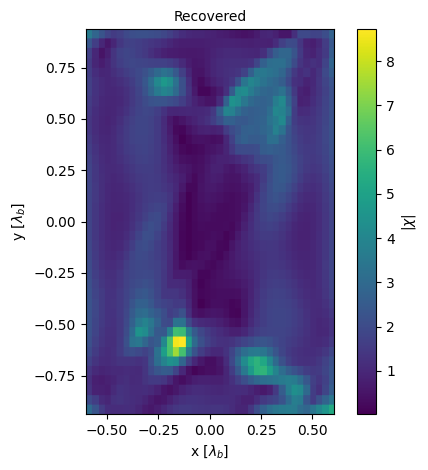

In [43]:
import som
import stopcriteria as stp

method = som.SubspaceBasedOptimizationMethod(
    stp.StopCriteria(max_iterations=30), cutoff_index=15
)

result = method.solve(test, discretization)

result.plot_map(show=True)